Glint Data Processing Master Script

In this script each of the four versions of the glint experiment are able to be processed into a master data sheet for each experiment. 

The experiments include:
(1) Original Familiar Glint
(2) Original Novel Glint
In both of these experiments, three conditions of transformed images are presented with only one stimulus duration. 

The second set of experiments include: 
(3) Familiar Glint Extreme 
(4) Novel Glint Extreme
In these two versions, three conditions of transformed images are presented with 4 different stimulus durations. 

The distinction between familiar and novel is that familiar shows participants previously learned images, while novel presents unknown images that are learned and then tested on. 


In [1]:
#Clear previous output and variables to ensure no mixing of the data
%reset -f

In [2]:
# Import Necessary Packages 
import os
import pandas as pd
import glob
import numpy as np
import pdb

In [12]:
#Parameters

path ='/zpool/vladlab/data_drive/glint_data/familiar_glint/5db0e17518230d00170d4332_familiar_glint_final_2025-11-19_11h19.45.749.csv'
df = pd.read_csv(path)

# Functions

Preprocessing Functions: 
1. experiment_parameters(experiment_type, is_extreme)

2. make_config(experiment_type, is_extreme, animacy_inclusion)

3. paths_of_interest(experiment, extreme)

4. new_trial_version(data, experiment, extreme, condition, animacy_inclusion, animacy=None, stimulus_duration=None)

5. filter_trials(trials, condition)

6. alternate_variables_of_interest(experiment, extreme, sub, condition, animacy_inclusion, trials, final_trials, number_of_no_responses, animacy=None, stimulus_duration=None)

7. preprocessing_pipeline(experiment_type, is_extreme, animacy_inclusion)

Exclusion functions:
1. determine_number_of_choices(experiment, extreme)

2. natural_accuracy_per_subject(sub_summary)

3. threshold_below_2sd(per_sub)

4. chance_calculator(number_of_choices)

5. flag_below_chance(sub_summary, number_of_choices)

6. flag_below_2sd(sub_summary, flagged_below_chance)

7. remove_flagged_subjects(sub_summary, flagged, delete=True)

8. create_wide_format(cleaned)

9. save_sub_summary(long_df, wide_df, experiment, extreme, output_path)

In [16]:
def preprocessing_pipeline(experiment_type, is_extreme):
    """Preprocess GLINT data based on experiment type and extreme flag.
    1. Sets experiment parameters.
    2. Loads data files.
    3. Loops through subjects, conditions, stimulus duration, and animacy to filter trials and calculate accuracy.
    4. Compiles results into a summary dataframe.
    
    Inputs: 
        experiment_type (str): 'novel' or 'familiar' to specify experiment version.
        is_extreme (bool): True for extreme version, False for original version.
    Returns:
        sub_summary (pd.DataFrame): Summary dataframe with accuracy and trial counts.
        settings (dict): Configuration dictionary with experiment parameters.
        experiment (str): Experiment version used.
        extreme (bool): Extreme flag used.
    """

    ''' Experiment parameters and settings (1 & 2 are inputs, 3-7 defined by inputs or hard coded)
    1. experiment (novel or familiar)
    2. extreme flag (True for extreme version, False for original version)
    3. durations (if extreme is True) 
    4. animacies
    5. base path for data
    6. file paths for the selected experiment version
    7. base columns for summary dataframe
    '''
    settings = {'experiment': experiment_type,'extreme': is_extreme,}
    
    experiment = settings['experiment'] #version of the experiment: familiar or novel

    extreme = settings['extreme'] # Sets extreme flag to determine if this is the extreme version of the experiment or not
    

    if extreme == True:
        durations = [0.3, 0.136, 0.068, 0.034] if extreme == True else [None] #durations only matter if extreme is True
    elif extreme == False:
        durations = [0.3] #if not extreme, duration is not applicable

    animacies = ['anim_natural', 'inanim_natural', 'inanim_artificial']


    # Define the columns for the summary dataframe, this will be used to compile the results for each subject and condition
    base_cols = ['experiment_label', 
                'sub', #subject identifier
                'condition', #condition (natural, scrambled, line_drawing)
                'stimulus_duration',#stimulus duration (only if extreme is True)
                'animacy', #animacy (only if animacy_inclusion is True)
                'un_filtered_acc', #accuracy before filtering
                'filtered_acc', #accuracy after filtering
                'no_responses', #number of no responses
                'num_trials_after_exclusion', #number of trials after all exclusions
                'num_of_outliers', #number of RT outliers
                'num_of_fast_responses', #number of fast responses (RT < 100ms)
                'total_number_of_excluded_trials'] #total number of excluded trials (no responses + fast responses + RT outliers)
    
    sub_summary = pd.DataFrame(columns=base_cols) #initialize empty dataframe with the appropriate columns, this will hold the final summary data


    #Need to differentiate the file paths based on if this is extreme or not
    base = '/zpool/vladlab/data_drive/glint_data' #base path for the data, this is the same for all versions of the experiment
    if extreme == True:
        core_path = f'{base}/{experiment}_glint_extreme' # set core path using experiment variable and base path
        print(f"You have selected {experiment} glint extreme experiment")

    elif extreme == False: 
        core_path = f'{base}/{experiment}_glint' # set core path using experiment variable and base path
        print(f"You have selected {experiment} glint experiment")


    #Now that they have selected the path for this version, it will gather all files associated with that version of the experiment    
    files = glob.glob(f'{core_path}/*.csv')  


    # Loop through each subject in this version of the experiment and process their data
    for file in files:
        print(f"\nProcessing file: {file}")
        try:
            predata = pd.read_csv(file) #read in the data file
        except Exception as e:
            print(f"Failed to read {file}: {e}")
            raise ValueError("No file by this name.")
        
    
        if 'participant' not in predata.columns:
            print(f"Error detected, 'participant' column missing in {file}")
            raise ValueError("Missing 'participant' column in data.") #Acts as a first layer defense to catch files that may not have the expected structure
        
        #Define a mapping of the data columns to standardize the column names across versions of the experiment 
        column_map = {
        "img_condition": "condition",
        "object_category": "animacy",
        "img_class": "test_object_class",
        "object_class": "test_object_class",}

        #rename the colimns to standardize across experiment versions
        data = predata.rename(columns=column_map)

        # Define a mapping for the conditions to standardize the condition names to their true names
        condition_mapping = {"natural": "natural", "scrambled": "feature", "line_drawing": "shape"}
        
        #Standardize the condition names in the data using the mapping
        data["condition"] = data["condition"].replace(condition_mapping)

        #get subject identifier from the data
        sub = data.loc[0, 'participant']

        #initialize empty dataframe for this subject's conditions to hold the summary data for each loop through the conditions, stimulus durations, and animacies
        condition_summary = pd.DataFrame(columns=sub_summary.columns)
        
        # Check practice accuracy if column exists
        if 'prac_key_resp.corr' in data.columns:
            practice_trials = data['prac_key_resp.corr'].mean() #calculate practice trials accuracy
            #print(f"  Practice trials accuracy: {practice_trials:.3f}")
            if practice_trials < 0.05:
                print(f"  Caution: Low accuracy in practice trials for {file} Accuracy =  {practice_trials:.3f}. Check data quality.")
            elif practice_trials >= 0.05:
                continue
        else:
            print(f"  Warning: 'prac_key_resp.corr' column not found in {file}")
        # Loop through each condition
        for condition in ['natural', 'feature', 'shape']:
            
            # Check for required columns
            needed = ['key_resp.corr', 'response_label','test_object_class','animacy','condition',]  #list of needed columns for processing
            if extreme == True:
                needed.append('stimulus_duration') #if extreme is True, we also need the stimulus duration column for processing
            
            if any(col not in data.columns for col in needed): 
                print(f"Missing expected columns in {file}") 
                raise ValueError("Missing expected columns in data.") #Second layer of defense to catch files that may be missing critical columns for the analysis
            

            # Define animacies based on animacy_inclusion
            animacies = ['anim_natural', 'inanim_natural', 'inanim_artificial']
            
            # Loop through stimulus durations and animacies if applicable
            for stimulus_duration in durations: 
                
                # Nested loop for animacy if applicable
                for animacy in animacies: #loop through each animacy
                    

                    # Use trials function to import trials and filter based on current parameters
                    if extreme == False:
                        trials = data[(data['condition'] == condition) & (data['animacy'] == animacy)] #if not extreme, we don't need to filter by stimulus duration, so we only filter by condition and animacy
                    
                    elif extreme == True:
                        trials = data[(data['condition'] == condition) & (data['stimulus_duration'] == stimulus_duration) & (data['animacy'] == animacy)]
                    
                    # Check if trials is None or empty, and will raise an error if so
                    if trials is None or len(trials) == 0:
                        print(f"  No trials found for {condition}, {animacy}, {stimulus_duration}")
                        raise ValueError("No trials found.")
                    
                    # Takes only trials with a response, and counts the number of no responses
                    no_response_filter = trials[trials['response_label'] != 'no response'] #filter out no responses
                    number_of_no_responses = len(trials) - len(no_response_filter) #count number of no responses


                    '''
                    Exclusion Criteria 1: RTs less than or equal to 100ms, and counts the number of fast responses
                    Exclusion Criteria 2: RTs outside mean ± 2*SD
                    We also remove no responses first, so that we are only looking at RTs for trials where there was a response, 
                    and then we apply the RT filters to those trials. This way we can accurately count 
                    the number of no responses, fast responses, and RT outliers separately.
                    '''

                    #Filters out RTs less than or equal to 100ms, and counts the number of fast responses
                    rt_less_equal_100 = no_response_filter[no_response_filter['key_resp.rt'] >= 0.100] #filter out RTs less than or equal to 100ms
                    number_of_fast_responses = len(no_response_filter) - len(rt_less_equal_100) #count number of RTs less than or equal to 100ms
    

                    #Calculates the mean and standard deviation of RTs for trials with RTs greater than 100ms, which will be used to identify outliers based on the mean ± 2*SD criterion
                    rt_plus_minus_2sd = rt_less_equal_100['key_resp.rt'].dropna() #drop NaN values
                    mean_rt = rt_plus_minus_2sd.mean() #calculate mean RT
                    std_rt = rt_plus_minus_2sd.std(ddof=1) #calculate standard deviation of RT
    
                    #Filters out RTs outside mean ± 2*SD, and counts the number of RT outliers
                    final_trials = rt_less_equal_100[rt_less_equal_100['key_resp.rt'].between(mean_rt - 2*std_rt, mean_rt + 2*std_rt)] #filter out RTs outside mean ± 2*SD

                    number_of_outliers = len(rt_less_equal_100) - len(final_trials) #count number of RT outliers
                        

                    # Calculate the variables of interest and compile into a row for condition summary
                    acc = trials['key_resp.corr'].mean() #accuracy before filtering
                    filtered_acc = final_trials['key_resp.corr'].mean() #accuracy after filtering   
                    trial_count = len(final_trials) #number of trials after all exclusions


                    #Combines the experiment and extreme parameters into a single label for the summary dataframe
                    extreme_label = 'extreme' if extreme else 'original' #create label for extreme status

                    experiment_label = f"{experiment}_{extreme_label}"  #combine experiment and extreme status into a single label for the summary dataframe    

                    #sums up the total number of trials for this condition, stimulus duration, and animacy that were excluded based on the filters applied
                    number_of_excluded_trials = number_of_no_responses + number_of_fast_responses + number_of_outliers 

                    #Compiles all the variables of interest into a row for the condition summary dataframe
                    row = {
                        'experiment_label': experiment_label, #experiment and extreme status
                        'sub': sub, #subject identifier
                        'condition': condition, #condition (natural, scrambled, line_drawing)
                        'stimulus_duration': stimulus_duration, #stimulus duration (only if extreme is True)
                        'animacy': animacy, #animacy (only if animacy_inclusion is True)
                        'un_filtered_acc': acc, #accuracy before filtering
                        'filtered_acc': filtered_acc, #accuracy after filtering
                        'no_responses': number_of_no_responses, #number of no responses
                        'num_trials_after_exclusion': trial_count, #number of trials after all exclusions
                        'num_of_outliers': number_of_outliers, #number of RT outliers
                        'num_of_fast_responses': number_of_fast_responses, #number of fast responses (RT < 100ms)
                        'total_number_of_excluded_trials': number_of_excluded_trials, #total number of excluded trials
                    }

                            
                    # Add the row to the condition summary
                    condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True) #append the row to the condition summary

        # After processing all conditions for this subject, append to the overall sub_summary
        sub_summary = pd.concat([sub_summary, condition_summary], ignore_index=True) #append the condition summary to the overall sub_summary


    return sub_summary, experiment, extreme  # return config so downstream steps use the same values

In [14]:
#Run the preprocessing pipeline for familiar Original version, experiment = 'familiar' and extreme = False
sub_summary, experiment, extreme = preprocessing_pipeline('familiar', False)


You have selected familiar glint experiment

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint/6678813aec86d687a654dedb_familiar_glint_final_2025-11-19_10h28.44.237.csv
  Practice Accuracy for /zpool/vladlab/data_drive/glint_data/familiar_glint/6678813aec86d687a654dedb_familiar_glint_final_2025-11-19_10h28.44.237.csv: 1.000

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint/5db0e17518230d00170d4332_familiar_glint_final_2025-11-19_11h19.45.749.csv
  Practice Accuracy for /zpool/vladlab/data_drive/glint_data/familiar_glint/5db0e17518230d00170d4332_familiar_glint_final_2025-11-19_11h19.45.749.csv: 1.000

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint/5aa2dcf36219a30001f57b7e_familiar_glint_final_2025-11-19_11h04.21.674.csv
  Practice Accuracy for /zpool/vladlab/data_drive/glint_data/familiar_glint/5aa2dcf36219a30001f57b7e_familiar_glint_final_2025-11-19_11h04.21.674.csv: 1.000

Processing file: /zpool/vladlab/data_drive/glint_dat

In [ ]:
def chance_calculator(experiment, extreme):
    """Return the number of response options for the given experiment/extreme combo."""
    mapping = {
        ('novel', False): 4,
        ('novel', True): 4,
        ('familiar', True): 6,
        ('familiar', False): 9,
    }

    number_of_choices = mapping.get((experiment, extreme))

    chance = 1 / number_of_choices #formula for calculating chance 
    print(f"Calculated chance level based on {number_of_choices} choices: {chance:.3f}")
    return chance

def exclusion_check(sub_summary,chance):
    """Returns per_sub DataFrame with natural condition accuracies per subject."""
    natural_acc = sub_summary[sub_summary['condition'] == 'natural'] # Filters for the condition of natural, and calculates the mean
    
    if natural_acc.empty:
        print("No 'natural' rows found in `sub_summary`.")
        # Return empty DataFrame with expected columns to avoid UnboundLocalError
        raise ValueError("No 'natural' rows found in sub_summary; cannot compute exclusion criteria.")
    
    per_sub = (
        natural_acc.groupby('sub', as_index=False)['filtered_acc']
        .mean()
        .rename(columns={'filtered_acc': 'natural_filtered_acc'})
    )

    """Calculate threshold for exclusion based on mean - 2*SD of natural accuracies."""
    mean_nat = per_sub['natural_filtered_acc'].mean() #calculate mean of natural filtered accuracy
    sd_nat = per_sub['natural_filtered_acc'].std(ddof=1) #calculate standard deviation of natural filtered accuracy
    thresh = mean_nat - 2 * sd_nat #calculate threshold as mean - 2*SD
    print(f"Natural condition: mean = {mean_nat:.3f}, sd = {sd_nat:.3f}, threshold (mean - 2sd) = {thresh:.3f}") #print threshold values
    
    ''' Flag subjects below chance level and below 2SD threshold, and print results.'''
    flagged_below_chance = per_sub[per_sub['natural_filtered_acc'] <= chance].copy() #flag subjects below chance level
    
    print(f"Chance threshold = {chance:.3f}") 
    print(f"Found {len(flagged_below_chance)} subject(s) below chance:") 
    if not flagged_below_chance.empty: 
        print(flagged_below_chance.sort_values('natural_filtered_acc')) #print flagged subjects below chance level
    

    flagged = per_sub[per_sub['natural_filtered_acc'] <= thresh].copy() #flag subjects below 2SD threshold
    
    print(f"Threshold for exclusion (mean - 2sd) = {thresh:.3f}")
    print(f"Found {len(flagged)} subject(s) below or equal to threshold:")
    if not flagged.empty:
        print(flagged.sort_values('natural_filtered_acc'))
    
    # Combine with flagged_below_chance if any
    if not flagged_below_chance.empty:
        flagged = pd.concat([flagged, flagged_below_chance], ignore_index=True).drop_duplicates()  #combine flagged subjects below chance with those below 2SD threshold
        print("Subjects below chance combined with subjects below 2SD threshold.")
    
    if flagged.empty:
        print("No subjects are below (or equal to) mean - 2*SD for natural filtered accuracy.")
    else:
        print(f"Flagged {len(flagged)} subject(s) total for exclusion:")
        print(flagged.sort_values('natural_filtered_acc'))
    
    return flagged 

def remove_flagged_subjects(sub_summary, flagged, delete=True):
    """Remove flagged subjects from sub_summary and returns cleaned data."""
    if flagged.empty:
        print("No subjects to remove based on exclusion criteria.")
        return sub_summary.copy() #return original sub_summary if no flagged subjects
    
    flagged_df = flagged.copy() #make a copy of flagged subjects DataFrame
    print(f"Flagged subjects to remove ({len(flagged_df)}):")
    print(flagged_df.sort_values('natural_filtered_acc'))
    
    flagged_subs = set(flagged_df['sub']) #get unique subject identifiers from flagged subjects
    n_rows_before = len(sub_summary) #count number of rows before removal
    n_rows_removed = sub_summary['sub'].isin(flagged_subs).sum() #count number of rows to be removed
    print(f"Preview: {n_rows_removed} rows (of {n_rows_before}) belong to flagged subject(s).") 
    
    if delete:
        cleaned = sub_summary[~sub_summary['sub'].isin(flagged_subs)].copy() #remove flagged subjects from sub_summary
        print(f"Removed {n_rows_removed} rows.")
    else:
        cleaned = sub_summary.copy() #keep original sub_summary if delete is False
        print("Delete=False: Keeping all rows in cleaned dataset.")
    
    return cleaned


def create_wide_format(cleaned):
    cleaned_wide = None
    try:
        values = ['un_filtered_acc', 'filtered_acc', 'no_responses', 'num_trials_after_exclusion'] #values to pivot on

        pivot_df = cleaned.pivot(index='sub', columns=['condition', 'stimulus_duration', 'animacy'], values=values) #pivot table with condition, stimulus_duration, and animacy as columns
        new_cols = [] #new column names list
        for col in pivot_df.columns:
            if len(col) == 3:
                metric, condition, duration = col 
                new_cols.append(f"{condition}_{duration}_{metric}") #format new column names
            else:
                new_cols.append("_".join([str(c) for c in col])) #join other columns as strings
        pivot_df.columns = new_cols
        pivot_df.reset_index(inplace=True)
        cleaned_wide = pivot_df #assign pivoted DataFrame to cleaned_wide

        
    except Exception as e:
        cleaned_wide = None
        print(f"Could not create wide-format: {e}")
    
    if cleaned_wide is None:
        print("Wide-format not created due to error.")
    return cleaned, cleaned_wide

# Exclusion Criteria Function (9) : Save Sub Summary
# Purpose: To save the cleaned long-format and wide-format DataFrames to CSV files
# This function avoids the use of global variables by taking all necessary parameters
# It saves the DataFrames to the specified output path

def save_sub_summary(long_df, wide_df, experiment, extreme, output_path):
    """No globals - takes all needed parameters."""
    version = 'extreme' if extreme else 'original' #determine version based on extreme status
    final_csv = f'{experiment}_glint_{version}_cleaned.csv' #construct final CSV filename

    long_df.to_csv(os.path.join(output_path, final_csv), index=False) #save long-format DataFrame to CSV
    print(f"Final cleaned sub_summary saved to {os.path.join(output_path, final_csv)}") 

    wide_df.to_csv(os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv'), index=False) #save wide-format DataFrame to CSV
    print(f"Final cleaned wide-format sub_summary saved to {os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv')}")


In [ ]:
chance = chance_calculator(experiment, extreme)
print(f"Running Exclusion check for experiment = {experiment}, extreme = {extreme}, chance level = {chance:.3f}")

flagged = exclusion_check(sub_summary,chance) #Flag subjects based on exclusion criteria

sub_summary_cleaned = remove_flagged_subjects(sub_summary, flagged, delete=True) # Remove flagged subjects

sub_summary_long_cleaned, sub_summary_wide_cleaned = create_wide_format(sub_summary_cleaned) # Create wide format





Calculated chance level based on 9 choices: 0.111
Running Exclusion check for experiment = familiar, extreme = False, chance level = 0.111
Natural condition: mean = 0.952, sd = 0.108, threshold (mean - 2sd) = 0.736
Chance threshold = 0.111
Found 0 subject(s) below chance:
Threshold for exclusion (mean - 2sd) = 0.736
Found 2 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Flagged 2 subject(s) total for exclusion:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163


Begin Preprocessing and Exclusion

Run the first cell to execute basic preprocessing to create a summary data frame.

Once complete, then run the exclusion criteria checks. 

In [9]:
# Step 2: Exclusion Criteria Checks
# Now that we have done trial exclusions and have a summarized version of the data, we need to perform participant exclusion

number_of_choices = determine_number_of_choices(cfg['experiment'], cfg['extreme']) # Determine number of choices for chance calculation

flagged_below_chance = flag_below_chance(sub_summary, number_of_choices) # Exclusion Criteria (1)

flagged = flag_below_2sd(sub_summary, flagged_below_chance) # Exclusion Criteria (2)

sub_summary_cleaned = remove_flagged_subjects(sub_summary, flagged, delete=True) # Remove flagged subjects

sub_summary_long_cleaned, sub_summary_wide_cleaned = create_wide_format(sub_summary_cleaned) # Create wide format


Calculated chance level based on 9 choices: 0.111
Chance threshold = 0.111
Found 0 subject(s) below chance:
Natural condition: mean = 0.952, sd = 0.108, threshold (mean - 2sd) = 0.736
Threshold for exclusion (mean - 2sd) = 0.736
Found 2 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Flagged 2 subject(s) total for exclusion:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Flagged subjects to remove (2):
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Preview: 18 rows (of 468) belong to flagged subject(s).
Removed 18 rows.


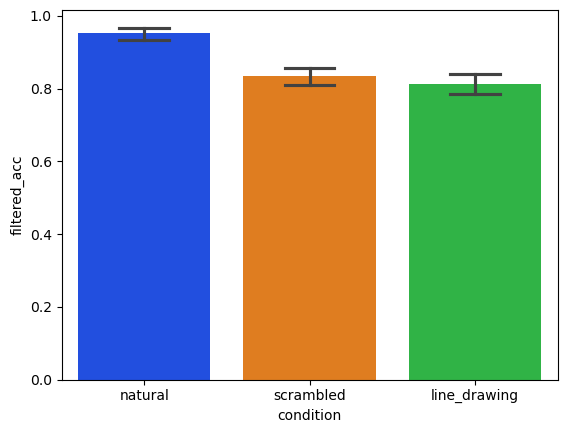

In [10]:
# Quick Visualization for debugging purposes
def plot_summary(sub_summary, extreme):
    import seaborn as sns
    import matplotlib.pyplot as plt
    if extreme == False: 
        sns.barplot(
            data=sub_summary,
            x="condition",
            y="filtered_acc",
            capsize=0.3,
            errorbar=("ci", 95),
            palette="bright",
            zorder=2,
            hue="condition"
        )
    elif extreme == True:
        sns.pointplot(
            data=sub_summary,
            x="stimulus_duration",
            y="filtered_acc",
            hue="condition",
            order=[0.3, 0.136, 0.068, 0.034],
            capsize=0.2,
            errorbar= ("ci", 95)
        )

plot_summary(sub_summary, extreme=False)

Save the Data

In [11]:
#Once visualization is complete, save the cleaned data frames
output_path = ('/zpool/vladlab/data_drive/glint_data/summary_data_csv/') #Path to save summary data CSV files

save_sub_summary(sub_summary_long_cleaned, sub_summary_wide_cleaned, 'familiar', False, output_path= '/zpool/vladlab/data_drive/glint_data/summary_data_csv/') # Save results